2D Parcels Test Model (depth and lon) - Matt

# Load packages and functions

In [1]:
%matplotlib inline
import parcels
from parcels import Field, FieldSet, ParticleSet, Variable, JITParticle, StatusCode
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc, animation
import xarray as xr
from datetime import datetime, timedelta
import os
import mocsy
from salishsea_tools import nc_tools, visualisations
from glob import glob

from IPython.display import Image
rc('animation', html='html5')

# Build parcels particle simulation

## Step 1: Define parcels FieldSet

In [2]:
# Pick hour, date, and location to grab vertical eddy diffusivity values from
hour = 0 
year = 2018
month = 8
day = 1

lat = 49.224563 
lon = -123.605357

jjii = xr.open_dataset('/home/sallen/MEOPAR/grid/grid_from_lat_lon_mask999.nc') # This is a file that gives the closest SalishSeaCast grid point (i and j) for a given lat and lon 
# j is the index along the SalishSeaCast grid (think y axis of model domain, or similar to latitude), while i is the index across the grid
j = [jjii.jj.sel(lats=lat, lons=lon, method='nearest').item()][0] # get the j index value that is closets to the chosen lat/lon coordinate (between 0-897)
i = [jjii.ii.sel(lats=lat, lons=lon, method='nearest').item()][0] # get the j index value that is closets to the chosen lat/lon coordinate (between 0-397)
print(j,i)

472 263


In [3]:
# Define filepath to pull SalishSeaCast results
path_NEMO = nc_tools.get_hindcast_prefix(date = datetime(year, month, day), res = 'h', version = '201905')
print(path_NEMO)

/results2/SalishSea/nowcast-green.201905/01aug18/SalishSea_1h_20180801_20180801


In [4]:
# Load W grid data from NEMO
Wdat = xr.open_dataset(path_NEMO+'_grid_W.nc', decode_times=False) # Opens the W grid data from SSC (vertical velocity grid but includes vertical eddy diffusivity)
# The .mbathy variable of the mesh_mask file is the index of the deepest grid cell (between 0-39)
mbathy = xr.open_dataset("/home/sallen/MEOPAR/grid/mesh_mask202108.nc").mbathy[0,j,i].item() # This saves the index of the deepest grid cell at the chosen horizontal grid cell (j,i coordinates)
depth = np.array(Wdat.depthw[:mbathy+1]).astype('float32') # this makes a list of the depth values of the grid cells from the first index to the index of mbathy + 1 (40 vertical grid cells in SSC but at this location there are only 37 and it includes the last because that represents the start of the next grid cell which would actually be the bottom?)
Kz_col = np.array(Wdat.vert_eddy_diff[hour,:mbathy+1,j,i]).astype('float32') # This extracts the vertical_eddy_diffusivity values from Wdat for the chosen range of vertical grid cells, at the chosen hour and horizontal grid cell (j,i coordinates)

In [5]:
# Define domain, velocity fields and Kz 
dim = 100 # length of fake longitude values for the 2D simulation
dep = len(depth) # length of the list of vertical grid cells at the chosen location for the 2D simulation
lon = np.linspace(0., 2e3, dim, dtype=np.float32) # creates a 1D array (a list) of 100 fake longitude values from 0 to 2000

# Build fieldsets for OceanParcels
# in parcels, 'U' represents the zonal flow velocity (zonal = east-to-west/west-to-east), and 'V' represents the meridional flow velocity (meridional = north-to-south/south-to-north)
U = Field('U', np.zeros((dep, dim), dtype=np.float32), lon=lon, depth=depth) # creates a fake parcels.Field object for the U field, filled with zeros (horizontal velocity = 0), with the dimensions = (dep, dim), so here thats 38 x 100
V = Field('V', np.zeros((dep, dim), dtype=np.float32), lon=lon, depth=depth) # creates a fake parcels.Field object for the V field, filled with zeros (horizontal velocity = 0), with the dimensions = (dep, dim), so here thats 38 x 100

Kz_data = np.zeros((dep, dim), dtype=np.float32) # creates an array filled with zeros the shape = (dep, dim), so here thats 38 x 100

for i in range(dim): # loop, from i = 0 to 100
    Kz_data[:,i]=Kz_col   # this assigns the list of 38 Kz values (1 for each vertical grid cell) to each of the 100 fake longitude values

Kz = Field('Kz', Kz_data, grid=U.grid) # this creates a parcels.Field object out of the Kz data array you just created

fieldset = FieldSet(U,V) # creates a fieldset with your fake U and V grids with zero volocity
fieldset.add_field(Kz) # adds your custom Kz field to the fieldset
# You now have a functional custom parcels fieldset to run particles in

/home/mattmiller/conda_envs/analysis-matt/lib/python3.10/site-packages/parcels/grid.py:88: RuntimeWarning: All-NaN slice encountered
  [np.nanmin(lon), np.nanmax(lon), np.nanmin(lat), np.nanmax(lat)], dtype=np.float32


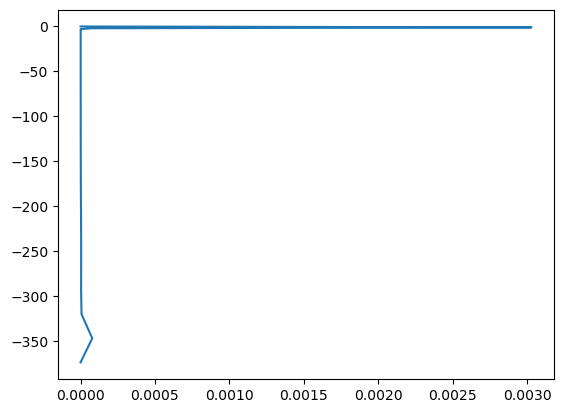

In [6]:
# Plot depth profile of vertical eddy diffusivity
plt.plot(Kz_col,-depth)

In [ ]:
# Add field for DIC, TA, S, etc. to fieldset to later calculate OmegaA experienced by the particles

## Step 2: Define parcels ParticleSet

additional Variables can be added to the particles (e.g. temperature, to keep track of the temperature that particles experience).

In [7]:
# Define a new particleclass with Variables 'Kh' and 'bath'
class Particle(parcels.JITParticle):
    age = Variable('age', initial =  0.0) # add a variable to keep track of the particle's age - might not need this for final model
    Kh = Variable('Kh', initial =  0.0) # this adds the variable kh which is horizontal eddy diffusivity, and sets it to be 0 - in this simulation I'm only using kz (vertical eddy diffusivity)
    bath = Variable('bath', initial = depth[-1]) # this adds the variable bath which is the particle's bathymetry; basically it keeps track of what the bottom depth is for a given particle - could use this to force the particles to swim up when they hit depth = bath

# Set the release coordinates: start with random distribution of N number of particles
N = 10e3 # number of particles
lon_g = np.random.uniform(low=lon[0], high=lon[-1], size=(int(N),))
depth_g = np.random.uniform(low=depth[0], high=depth[-1], size=(int(N),))
lat_g = np.zeros(int(N),)

# Define the particle set using the particle class you just created
pset = parcels.ParticleSet(
    fieldset=fieldset,  # the fields that the particleset uses
    pclass=Particle,  # define the class of particle
    lon=lon_g,  # release longitude
    lat=lat_g,  # release latitude
    depth = depth_g # release depth
) 

## Step 3: Define parcels particle kernels

In [8]:
# Create a custom kernel which keeps track of the particle age (minutes)
def age_kernel(particle, fieldset, time):
    particle.age += particle.dt / 3600

In [9]:
# Mixing Kernel - I'm not sure what most of these lines do
def mix_kernel(particle,fieldset,time): 
    bath = particle.bath 
    if particle.depth+1 > bath: #Forward euler
        Kzdz = (fieldset.Kz[time,particle.depth,particle.lat, particle.lon]-fieldset.Kz[time,particle.depth-1,particle.lat, particle.lon]) #forward difference 
    else:
        Kzdz = (fieldset.Kz[time,particle.depth+1,particle.lat, particle.lon]-fieldset.Kz[time,particle.depth,particle.lat, particle.lon]) #backward difference 
    dgrad = Kzdz * particle.dt 
    if particle.depth+0.5*dgrad > 0 and particle.depth+0.5*dgrad < bath:
        kk = fieldset.Kz[time,particle.depth+0.5*dgrad,particle.lat, particle.lon] #Vertical diffusivity SSC  
    else:
        kk = fieldset.Kz[time, bath,particle.lat, particle.lon] #Vertical diffusivity SSC 
    Kx = particle.Kh
    Rr = ParcelsRandom.uniform(-1, 1)
    Rr2 = ParcelsRandom.uniform(-1, 1)
    d_random = sqrt(3*2*kk*particle.dt) * Rr
    d_randomx = sqrt(3*2*Kx*particle.dt) * Rr2
    Dlayerz = 0.5*sqrt(kk * particle.dt) #1m mixing layer
    Dlayerx = 0.5*sqrt(Kx * particle.dt)
    if particle.lon + d_randomx < 0:
        particle.lon = Dlayerx * ParcelsRandom.uniform(0, 1)
    elif particle.lon + d_randomx > 2e3:
        particle.lon = 2e3 - Dlayerx * ParcelsRandom.uniform(0, 1)
    else: 
        particle.lon=particle.lon + d_randomx
    if d_random + dgrad +particle.depth > bath: #randomly in boundary mixed layer
        particle.depth = bath - Dlayerz * ParcelsRandom.uniform(0, 1)
    elif d_random +particle.depth +dgrad < 0:
            particle.depth = Dlayerz * ParcelsRandom.uniform(0, 1) #Well mixed boundary layer
    else:
        particle.depth += d_random + dgrad 

In [10]:
# Swimming Kernel - 40 mm/s sink, 30 mm/s swim
def swim_kernel(particle, fieldset, time):
    mbath = particle.bath
    sink = 40e-3 # m/s (initial = 20e-3) the sinking speed should exceed the swimming speed. the random direction change switches them between swimming and sinking, and the 1.05 means they are swimming 5% more often than sinking
    swim = 30e-3 # m/s (initial = 32.5e-3)
    dt = 200 # how often they change direction
    kappa = swim**2 * dt # Double asterisk means exponential
    eff_swim = sqrt(kappa / particle.dt) # what does eff_swim represent?
    upward = 1.05   # tendency to swim more upward than sink
    zswim = (- particle.dt * (upward-1) * sink + particle.dt * (eff_swim - upward*sink) * math.cos(ParcelsRandom.uniform(0, 2* math.pi))) # what does zswim represent?
    if particle.depth + zswim < 0:
        particle.depth = 0
    elif particle.depth + zswim > mbath:
        particle.depth = mbath
    else:
        particle.depth += zswim

In [11]:
# Delete particle kernel: Delete particle from OceanParcels simulation to avoid run failure if particle goes out of bounds
def delete_particle_kernel(particle, fieldset, time):
    if particle.state == StatusCode.ErrorOutOfBounds:
        particle.delete()

In [12]:
# define all kernels to be executed on particles using an (ordered) list
kernels = [age_kernel, mix_kernel, swim_kernel, delete_particle_kernel] # keep delete_particle_kernel at end of kernel list, otherwise later Kernels may overwrite the particle.state or the particle_dlon variables

## Step 4: Execute parcels simulation

In [ ]:
# Define the output file
outputdt = 3600 # the time period (in seconds) between consecutive output steps (3600 = 1 hr)
outputpath = '/ocean/mattmiller/MOAD/results/parcels/test/iteration_1.zarr' # this makes sure the results are saved in the folder of this iteration
#days = 6 # the total length of the run (in days)
#runtime = days * 86400 # converts runtime from days to seconds (86400 s = 24 hours = 1 day)
runtime = timedelta(days=6) # the total length of the run (in days)
#dt = 5 # particle timestep (in seconds)
dt = timedelta(minutes=5) # particle timestep (in seconds)

output_file = pset.ParticleFile(
    name = outputpath, # output file name
    outputdt = outputdt, # output timestep
    #chunks = (N, 10),  # the chunking of the output file (number of particles, timesteps). It will generally be much more efficient if chunks[0]*chunks[1] is (much) greater than several thousand.
)

pset.execute(
    kernels,  # the list of kernels (which defines how particles move)
    runtime = runtime, 
    dt = dt, 
    output_file = output_file,
)

INFO: Output files are stored in /ocean/mattmiller/MOAD/results/parcels/test/Outputmix_sink_and_swim_6_days_test.zarr.


/home/mattmiller/conda_envs/analysis-matt/lib/python3.10/site-packages/parcels/particleset.py:1089: FileWarning: Some of the particles have a start time that is not a multiple of outputdt. This could cause the first output to be at a different time than expected.
  _warn_outputdt_release_desync(outputdt, self.particledata.data["time_nextloop"])


100%|██████████| 518400.0/518400.0 [06:46<00:00, 1274.45it/s]


## Load results from previous parcels simulations

In [16]:
dat = xr.load_dataset(outputpath)

/home/mattmiller/conda_envs/analysis-matt/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/mattmiller/conda_envs/analysis-matt/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


In [17]:
# View data
print(dat)

<xarray.Dataset> Size: 46MB
Dimensions:     (trajectory: 10000, obs: 144)
Coordinates:
  * obs         (obs) int32 576B 0 1 2 3 4 5 6 7 ... 137 138 139 140 141 142 143
  * trajectory  (trajectory) int64 80kB 0 1 2 3 4 5 ... 9995 9996 9997 9998 9999
Data variables:
    Kh          (trajectory, obs) float32 6MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    age         (trajectory, obs) float32 6MB 0.002778 1.003 ... 142.0 143.0
    bath        (trajectory, obs) float32 6MB 374.1 374.1 374.1 ... 374.1 374.1
    lat         (trajectory, obs) float32 6MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    lon         (trajectory, obs) float32 6MB 573.3 573.3 573.3 ... 273.6 273.6
    time        (trajectory, obs) timedelta64[ns] 12MB 00:00:05 ... 5 days 23...
    z           (trajectory, obs) float32 6MB 267.2 276.4 253.8 ... 14.81 1.521
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:   

Text(0.5, 0.98, 'Sink and Swim')

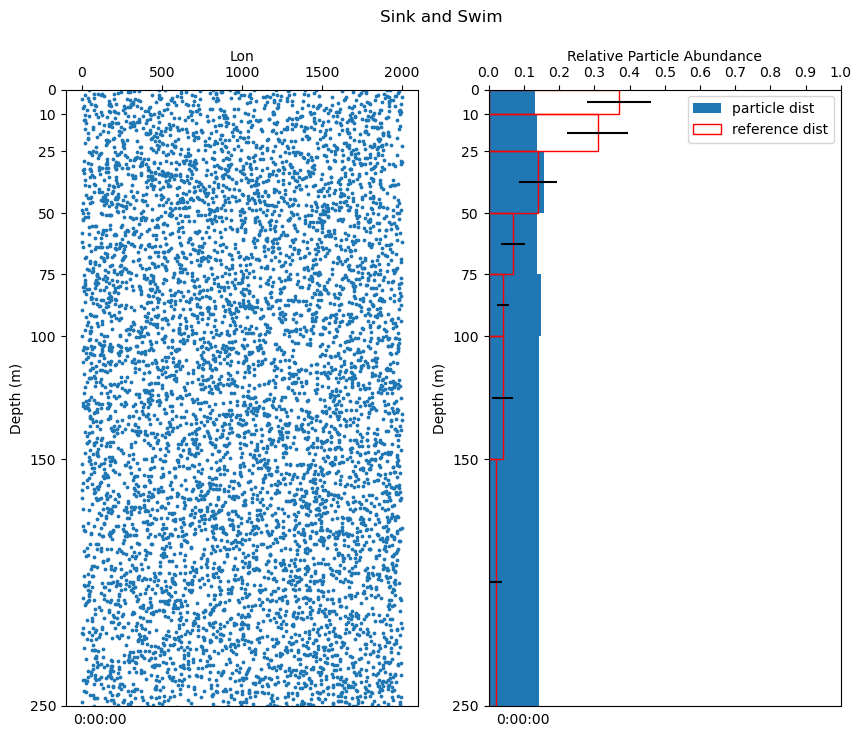

In [18]:
# plot initial timestep
counts, bins = np.histogram(dat.z[:, 0], bins=[0, 10, 25, 50, 75, 100, 150, 250]) # Calculate the counts and bins for the histogram
bin_centers = [0,  10,  25,  50,  75, 100, 150] # Calculate the bin centers (for placing bins on the y-axis
binwidths = np.diff(bins) #[10, 15, 25, 25, 25, 50, 100] # Define the binwidths
relative_abundance = (counts/binwidths)/sum(counts/binwidths) # Calculate the relative particle abundance
vertical_dist = [0.37, 0.31, 0.14, 0.07, 0.04, 0.04, 0.02] # bin means from all day and night LimS0 standard interval tows
xerr = [0.090, 0.087, 0.053, 0.034, 0.017, 0.030, 0.017] # 95% confidence intervals for the means from all day and night LimS0 standard interval tows (n = 38)
tstamp = dat.time[0, 0].values.astype('timedelta64[D]').astype(datetime)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,8))
ax1.scatter(dat.lon[:,0],dat.z[:,0],s=3,c ='tab:blue')
ax1.set_yticks(bins, bins) # Set the tick positions and labels for the y-axis
ax1.set_ylim(0, 250)
ax1.invert_yaxis()
ax1.xaxis.tick_top()
ax1.xaxis.set_label_position('top')
ax1.set_xlabel('Lon')
ax1.set_ylabel('Depth (m)')
ax1.text(x = 0.02, y = -0.03, s = tstamp, transform=ax1.transAxes)
ax2.barh(bin_centers, relative_abundance, label = 'particle dist', height=binwidths, align='edge', color='tab:blue') # Create the histogram with bins on the y-axis and counts on the x-axis
ax2.barh(bin_centers, vertical_dist, label = 'reference dist', height=binwidths, align='edge', color='none', edgecolor ='r', xerr = xerr) # Plot reference vertical distribution
ax2.set_yticks(bins, bins) # Set the tick positions and labels for the y-axis
ax2.set_ylim(0, 250)
ax2.invert_yaxis()
ax2.set_xticks(np.arange(0, 1.1, 0.1)) # Set the tick positions and labels for the x-axis
ax2.xaxis.tick_top()
ax2.xaxis.set_label_position('top')
ax2.set_xlabel('Relative Particle Abundance') # Add labels and title
ax2.set_ylabel('Depth (m)')
ax2.text(x = 0.02, y = -0.03, s = tstamp, transform=ax2.transAxes)
ax2.legend()
plt.suptitle('Sink and Swim')

Text(0.5, 0.98, 'Sink and Swim')

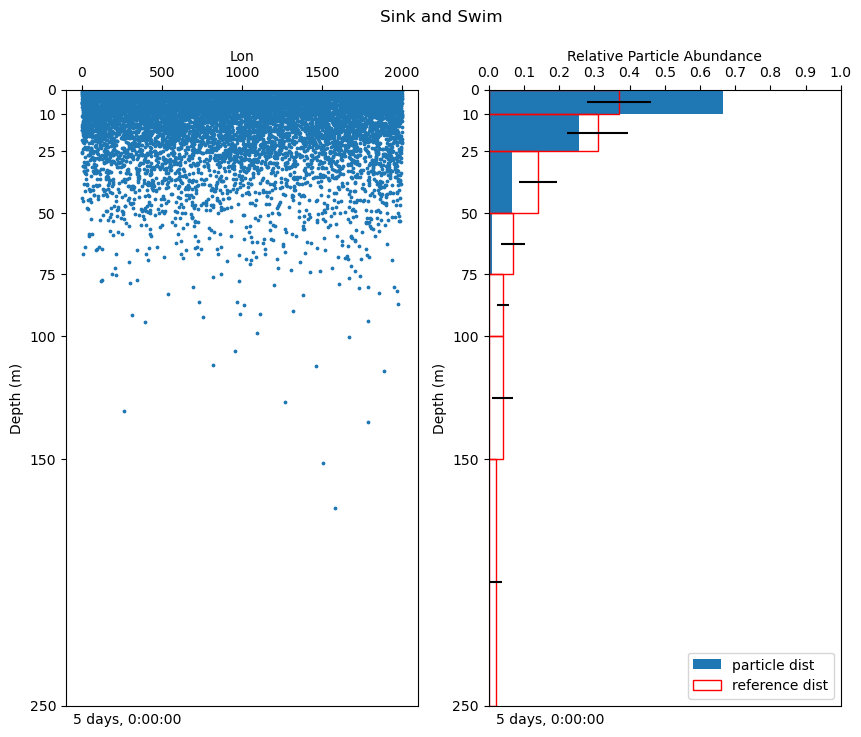

In [19]:
# plot final timestep
counts, bins = np.histogram(dat.z[:, -1], bins=[0, 10, 25, 50, 75, 100, 150, 250]) # Calculate the counts and bins for the histogram
bin_centers = [0,  10,  25,  50,  75, 100, 150] # Calculate the bin centers (for placing bins on the y-axis
binwidths = np.diff(bins) #[10, 15, 25, 25, 25, 50, 100] # Define the binwidths
relative_abundance = (counts/binwidths)/sum(counts/binwidths) # Calculate the relative particle abundance
vertical_dist = [0.37, 0.31, 0.14, 0.07, 0.04, 0.04, 0.02] # bin means from all day and night LimS0 standard interval tows (n = 38)
xerr = [0.090, 0.087, 0.053, 0.034, 0.017, 0.030, 0.017] # 95% confidence intervals for the means from all day and night LimS0 standard interval tows (n = 38)
tstamp = dat.time[0, -1].values.astype('timedelta64[D]').astype(datetime) # This is likely more computationally efficient than the above line, but doesn't give decimal places. Can change [D] to [M] for months

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,8))
ax1.scatter(dat.lon[:,-1],dat.z[:,-1],s=3,c ='tab:blue')
ax1.set_yticks(bins, bins) # Set the tick positions and labels for the y-axis
ax1.set_ylim(0, 250)
ax1.invert_yaxis()
ax1.xaxis.tick_top()
ax1.xaxis.set_label_position('top')
ax1.set_xlabel('Lon')
ax1.set_ylabel('Depth (m)')
ax1.text(x = 0.02, y = -0.03, s = tstamp, transform=ax1.transAxes)
ax2.barh(bin_centers, relative_abundance, label = 'particle dist', height = binwidths, align = 'edge', color = 'tab:blue') # Create the histogram with bins on the y-axis and counts on the x-axis
ax2.barh(bin_centers, vertical_dist, label = 'reference dist', height = binwidths, align = 'edge', color = 'none', edgecolor ='r', xerr = xerr) # Plot reference vertical distribution
ax2.set_yticks(bins, bins) # Set the tick positions and labels for the y-axis
ax2.set_ylim(0, 250)
ax2.invert_yaxis()
ax2.set_xticks(np.arange(0, 1.1, 0.1)) # Set the tick positions and labels for the x-axis
ax2.xaxis.tick_top()
ax2.xaxis.set_label_position('top')
ax2.set_xlabel('Relative Particle Abundance') # Add labels and title
ax2.set_ylabel('Depth (m)')
ax2.text(x = 0.02, y = -0.03, s = tstamp, transform=ax2.transAxes)
ax2.legend()
plt.suptitle('Sink and Swim')